# Advantage Actor-Critic with TensorFlow 2.1

## Setup

In [13]:
import gym
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko

%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.1.0


In [14]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


## Policy & Value Model Class

In [15]:
class ProbabilityDistribution(tf.keras.Model):
  def call(self, logits, **kwargs):
    # Sample a random categorical action from the given logits.
    return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)


class Model(tf.keras.Model):
  def __init__(self, num_actions):
    super().__init__('mlp_policy')
    # Note: no tf.get_variable(), just simple Keras API!
    self.hidden1 = kl.Dense(128, activation='relu')
    self.hidden2 = kl.Dense(128, activation='relu')
    self.value = kl.Dense(1, name='value')
    # Logits are unnormalized log probabilities.
    self.logits = kl.Dense(num_actions, name='policy_logits')
    self.dist = ProbabilityDistribution()

  def call(self, inputs, **kwargs):
    # Inputs is a numpy array, convert to a tensor.
    x = tf.convert_to_tensor(inputs)
    # Separate hidden layers from the same input tensor.
    hidden_logs = self.hidden1(x)
    hidden_vals = self.hidden2(x)
    return self.logits(hidden_logs), self.value(hidden_vals)

  def action_value(self, obs):
    # Executes `call()` under the hood.
    logits, value = self.predict_on_batch(obs)
    action = self.dist.predict_on_batch(logits)
    # Another way to sample actions:
    #   action = tf.random.categorical(logits, 1)
    # Will become clearer later why we don't use it.
    return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

In [16]:
# Verify everything works by sampling a single action.
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
model.action_value(env.reset()[None, :])

(array(1), array([1.0734191e-05], dtype=float32))

## Advantage Actor-Critic Agent Class

In [17]:
class A2CAgent:
  def __init__(self, model, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-4):
    # `gamma` is the discount factor; coefficients are used for the loss terms.
    self.gamma = gamma
    self.value_c = value_c
    self.entropy_c = entropy_c

    self.model = model
    self.model.compile(
      optimizer=ko.RMSprop(lr=lr),
      # Define separate losses for policy logits and value estimate.
      loss=[self._logits_loss, self._value_loss])

  def train(self, env, batch_sz=64, updates=250):
    # Storage helpers for a single batch of data.
    actions = np.empty((batch_sz,), dtype=np.int32)
    rewards, dones, values = np.empty((3, batch_sz))
    observations = np.empty((batch_sz,) + env.observation_space.shape)
    # Training loop: collect samples, send to optimizer, repeat updates times.
    ep_rewards = [0.0]
    next_obs = env.reset()
    for update in range(updates):
      for step in range(batch_sz):
        observations[step] = next_obs.copy()
        actions[step], values[step] = self.model.action_value(next_obs[None, :])
        next_obs, rewards[step], dones[step], _ = env.step(actions[step])

        ep_rewards[-1] += rewards[step]
        if dones[step]:
          ep_rewards.append(0.0)
          next_obs = env.reset()
          logging.info("Episode: %03d, Reward: %03d" % (len(ep_rewards) - 1, ep_rewards[-2]))

      _, next_value = self.model.action_value(next_obs[None, :])
      returns, advs = self._returns_advantages(rewards, dones, values, next_value)
      # A trick to input actions and advantages through same API.
      acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
      # Performs a full training step on the collected batch.
      # Note: no need to mess around with gradients, Keras API handles it.
      losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
      logging.debug("[%d/%d] Losses: %s" % (update + 1, updates, losses))

    return ep_rewards

  def test(self, env, render=False):
    obs, done, ep_reward = env.reset(), False, 0
    while not done:
      action, _ = self.model.action_value(obs[None, :])
      obs, reward, done, _ = env.step(action)
      ep_reward += reward
      if render:
        env.render()
    return ep_reward

  def _returns_advantages(self, rewards, dones, values, next_value):
    # `next_value` is the bootstrap value estimate of the future state (critic).
    returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
    # Returns are calculated as discounted sum of future rewards.
    for t in reversed(range(rewards.shape[0])):
      returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
    returns = returns[:-1]
    # Advantages are equal to returns - baseline (value estimates in our case).
    advantages = returns - values
    return returns, advantages

  def _value_loss(self, returns, value):
    # Value loss is typically MSE between value estimates and returns.
    return self.value_c * kls.mean_squared_error(returns, value)

  def _logits_loss(self, actions_and_advantages, logits):
    # A trick to input actions and advantages through the same API.
    actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
    # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
    # `from_logits` argument ensures transformation into normalized probabilities.
    weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
    # Policy loss is defined by policy gradients, weighted by advantages.
    # Note: we only calculate the loss on the actions we've actually taken.
    actions = tf.cast(actions, tf.int32)
    policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
    # Entropy loss can be calculated as cross-entropy over itself.
    probs = tf.nn.softmax(logits)
    entropy_loss = kls.categorical_crossentropy(probs, probs)
    # We want to minimize policy and maximize entropy losses.
    # Here signs are flipped because the optimizer minimizes.
    return policy_loss - self.entropy_c * entropy_loss

In [18]:
# Verify everything works with random weights.
agent = A2CAgent(model)
rewards_sum = agent.test(env)
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 18 out of 200


## Training A2C Agent & Results

INFO:root:Episode: 001, Reward: 013
INFO:root:Episode: 002, Reward: 024
INFO:root:Episode: 003, Reward: 015
INFO:root:Episode: 004, Reward: 012
INFO:root:Episode: 005, Reward: 012
INFO:root:Episode: 006, Reward: 023
INFO:root:Episode: 007, Reward: 023
INFO:root:Episode: 008, Reward: 021
INFO:root:Episode: 009, Reward: 021
INFO:root:Episode: 010, Reward: 022
INFO:root:Episode: 011, Reward: 023
INFO:root:Episode: 012, Reward: 036
INFO:root:Episode: 013, Reward: 024
INFO:root:Episode: 014, Reward: 023
INFO:root:Episode: 015, Reward: 009
INFO:root:Episode: 016, Reward: 031
INFO:root:Episode: 017, Reward: 020
INFO:root:Episode: 018, Reward: 043
INFO:root:Episode: 019, Reward: 028
INFO:root:Episode: 020, Reward: 089
INFO:root:Episode: 021, Reward: 021
INFO:root:Episode: 022, Reward: 016
INFO:root:Episode: 023, Reward: 047
INFO:root:Episode: 024, Reward: 033
INFO:root:Episode: 025, Reward: 026
INFO:root:Episode: 026, Reward: 038
INFO:root:Episode: 027, Reward: 052
INFO:root:Episode: 028, Rewa

Finished training! Testing...
Total Episode Reward: 200 out of 200


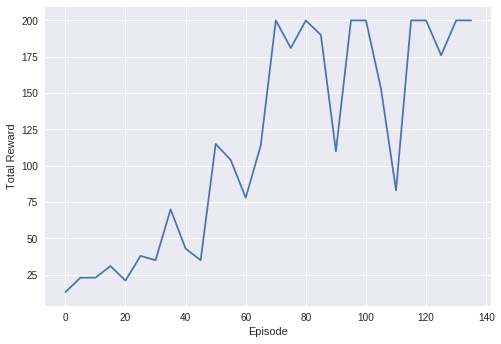

In [19]:
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.getLogger().setLevel(logging.INFO)

model = Model(num_actions=env.action_space.n)
agent = A2CAgent(model)

rewards_history = agent.train(env)
print("Finished training! Testing...")
print("Total Episode Reward: %d out of 200" % agent.test(env))

plt.style.use('seaborn')
plt.plot(np.arange(0, len(rewards_history), 5), rewards_history[::5])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

## Static Computational Graph

In [20]:
with tf.Graph().as_default():
    print("Eager Execution:", tf.executing_eagerly()) # False

    model = Model(num_actions=env.action_space.n)
    agent = A2CAgent(model)

    rewards_history = agent.train(env)
    print("Finished training! Testing...")
    print("Total Episode Reward: %d out of 200" % agent.test(env))

Eager Execution: False
Finished training! Testing...
Total Episode Reward: 200 out of 200


INFO:root:Episode: 001, Reward: 035
INFO:root:Episode: 002, Reward: 020
INFO:root:Episode: 003, Reward: 044
INFO:root:Episode: 004, Reward: 013
INFO:root:Episode: 005, Reward: 019
INFO:root:Episode: 006, Reward: 166
INFO:root:Episode: 007, Reward: 078
INFO:root:Episode: 008, Reward: 039
INFO:root:Episode: 009, Reward: 052
INFO:root:Episode: 010, Reward: 029
INFO:root:Episode: 011, Reward: 025
INFO:root:Episode: 012, Reward: 013
INFO:root:Episode: 013, Reward: 036
INFO:root:Episode: 014, Reward: 031
INFO:root:Episode: 015, Reward: 012
INFO:root:Episode: 016, Reward: 019
INFO:root:Episode: 017, Reward: 061
INFO:root:Episode: 018, Reward: 069
INFO:root:Episode: 019, Reward: 138
INFO:root:Episode: 020, Reward: 035
INFO:root:Episode: 021, Reward: 050
INFO:root:Episode: 022, Reward: 140
INFO:root:Episode: 023, Reward: 077
INFO:root:Episode: 024, Reward: 073
INFO:root:Episode: 025, Reward: 119
INFO:root:Episode: 026, Reward: 113
INFO:root:Episode: 027, Reward: 062
INFO:root:Episode: 028, Rewa

## Benchmarks

Note: wall time doesn't show the whole picture, it's better to compare CPU time.

In [21]:
# Generate 100k observations to run benchmarks on.
env = gym.make('CartPole-v0')
obs = np.repeat(env.reset()[None, :], 100000, axis=0)

### Eager Benchmark

In [22]:
%%time

model = Model(env.action_space.n)
model.run_eagerly = True

print("Eager Execution:  ", tf.executing_eagerly())
print("Eager Keras Model:", model.run_eagerly)

_ = model.predict_on_batch(obs)

Eager Execution:   True
Eager Keras Model: True
CPU times: user 24 ms, sys: 12.7 ms, total: 36.7 ms
Wall time: 35.1 ms


### Static Benchmark

In [23]:
%%time

with tf.Graph().as_default():
    model = Model(env.action_space.n)

    print("Eager Execution:  ", tf.executing_eagerly())
    print("Eager Keras Model:", model.run_eagerly)

    _ = model.predict_on_batch(obs)

Eager Execution:   False
Eager Keras Model: False
CPU times: user 81.6 ms, sys: 21 ms, total: 103 ms
Wall time: 99.6 ms


### Default Benchmark

In [24]:
%%time

model = Model(env.action_space.n)

print("Eager Execution:  ", tf.executing_eagerly())
print("Eager Keras Model:", model.run_eagerly)

_ = model.predict_on_batch(obs)

Eager Execution:   True
Eager Keras Model: False
CPU times: user 54.2 ms, sys: 4.58 ms, total: 58.7 ms
Wall time: 56 ms
